<a href="https://colab.research.google.com/github/kevinsu-rgb/Senior_Design_TI_Project/blob/main/modified_pedhrom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Version with windowed-merged datasets making 55x1 input, Dense only model.
- data is merged so bins are all mixed up ...
- WINDOW_SIZE = 5, gives the merged-sorted result
- WINDOW_SIZE = 1, gives the concatenated result, no merging due to WINDOW=Frame size


In [11]:
## All Hyper parameters

VISUALISE = False  # plot accumulated datasets or not ? (True/False)
DEMO = 'posture'  # example type

# Enumeration for each Category, \/\/\/\/\/ add new categories here along with data CSV's in folder of same name
class_data = {0: 'STANDING', 1: 'SITTING', 2: 'LYING', 3: 'FALLING', 4: 'WALKING'}

# Dataset feature formatting
WINDOW_SIZE = 8  # window size of frame data: 1,2,3,4,5,6 ... for example.
WINDOW_CONCATENATE = False  # concatenate each frame within the window or not (ie merge)
WINDOW_SORT = False  # Sort the window data or not (True or False)
MIN_POINTS = 5  # Minimum number of point cloud points for a row to be considered
EQUALISE_DATA_LENGTHS = False  # Set all categories to have the same rows as the fewest

# Data Filtering
FILTER = True
MAX_HEIGHT = 3
MIN_HEIGHT = -4
MAX_DISTANCE = 5
MIN_DISTANCE = -4
LOWEST_POINTS_INCLUDED = False

# Training topics
NUM_EPOCHS = 1600  # TRAINING: number of epochs to run
BATCH_SIZE = 64  # TRAINING: batch size of datasets defining the iterative model update, 64 is OK result.
TEST_SIZE_PERCENT = 20  # split dataset % between test(TEST_SIZE_PERCENT) and train(100-TEST_SIZE_PERCENT)
LEARNING_RATE = .0001  # Learning rate of the optimizer which determines the step size at each iteration while moving toward a minimum of a loss function
F1_SCORE_THRESH = 0.5  # Threshold for converting input into predicted labels for each sample.
# Compute binary f1 score, which is defined as the harmonic mean of precision and recall.



In [12]:
import torch

torch.manual_seed(42)

import torch.nn as nn
import pandas as pd
from torch.optim import SGD
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch.onnx
import sys
from pathlib import Path
import os
import math

print(f"Python version: {sys.version}")
print(f"torch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CPU instances: {os.cpu_count()}")

# setup module path for helper functions
# from modules.helper_functions import accuracy_fn

##################################################################
# If you have a GPU that supports CUDA, I heavily suggest you    #
# set device to CUDA rather than CPU for significantly increased #
# model training speeds                                          #
##################################################################

if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}, instances:{torch.cuda.device_count()}")
  device = "cuda"
else:
  device = "cpu"

torch.device(device)
print(f"New Device: {device}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
torch version: 2.9.0+cpu
CUDA version: None
CPU instances: 2
New Device: cpu


### Look for the dataset files and find the classes.

In [13]:
# Setup path to data folder
data_path = Path(os.getcwd() + "/dataset")
print(data_path)
class_path = Path(f"{data_path}/classes/")

# Find the class names (according to folder structure)
class_names = [f for f in os.listdir(class_path)]

file_names = [f for f in list(class_path.rglob("*.csv"))]
print(f"File names: {file_names}")
print(f"# of Files: {len(file_names)}")


/content/dataset
File names: [PosixPath('/content/dataset/classes/sitting/results_SAT_ED_160805.csv'), PosixPath('/content/dataset/classes/sitting/results_SAT_FAIK_165546.csv'), PosixPath('/content/dataset/classes/sitting/results_SAT_EDDIE_165532.csv'), PosixPath('/content/dataset/classes/sitting/results_SAT_DYLAN_170501.csv'), PosixPath('/content/dataset/classes/sitting/replay_2025-09-18_14-47-34_final.csv'), PosixPath('/content/dataset/classes/sitting/replay_2025-08-22_13-44-11swap.csv'), PosixPath('/content/dataset/classes/sitting/replay_2025-09-18_14-52-28_final.csv'), PosixPath('/content/dataset/classes/sitting/replay_2025-09-18_14-47-34swap.csv'), PosixPath('/content/dataset/classes/sitting/results_SAT_EMMANUEL_181059.csv'), PosixPath('/content/dataset/classes/standing/results_STOOD_EMMANUEL180704.csv'), PosixPath('/content/dataset/classes/standing/results_STOOD_ED_160456.csv'), PosixPath('/content/dataset/classes/standing/replay_2025-08-22_13-48-32swap.csv'), PosixPath('/content

### Read in the data from the CSV files and concatenate into single dataframe
- Read in the CSV files and concatenate into one large dataset.
- Sort the rows by classification column.  
- separate the classes, and count how many of each classification are present.  
- Visualise the datasets.

In [14]:


# %%writefile modules/data_setup.py
"""
Read in the data from the CSV files and concatenate into single dataframe
"""

## Read in the CSV files and concatenate into one large dataset.
## Remove collection information columns and add classification column
## Remove any rows with invalid data (not enough points or invalid track ID)
df_csv_append = pd.DataFrame()
for file in file_names:
    df = pd.read_csv(file, encoding='utf-8', engine='python')

    # Add tracker columns to datasets that may not have recorded it
    required = [
        "posx", "posy", "posz",
        "velx", "vely", "velz",
        "accx", "accy", "accz"
    ]

    # Add any missing ones with a default of 0
    for col in required:
        if col not in df.columns:
            df[col] = 0   # pandas automatically broadcasts the scalar to all rows

    classification = os.path.basename(os.path.dirname(file)).upper()
    value = -1
    for key, val in class_data.items():
        if val == classification:
            value = key
    if 'Session_ID' in df.columns:
        df.drop(['Session_ID', 'Recording_Number'], axis=1, inplace=True)
    df.insert(0, 'classification', value)
    print(f'{file.name}: {df.shape}')
    dropped = 0
    for index, row in df.iterrows():
            # First check if either column exists in the DataFrame
        if 'Track ID' in df.columns:
            track_id_col = 'Track ID'
        elif 'tid' in df.columns:
            track_id_col = 'tid'
        else:
            # Handle the case where neither column exists
            print(f"Warning: Neither 'Track ID' nor 'tid' found in file {file.name}")
            df.drop(index, inplace=True)
            dropped += 1
            continue

        # Now check the condition using the identified column
        if (row.notna().sum() < (9 + 3 * MIN_POINTS)) or not str(float(row[track_id_col])).endswith('.0'):
            df.drop(index, inplace=True)
            dropped += 1

    print(f"Dropped {dropped} rows for invalid data")

    df_csv_append = pd.concat([df_csv_append, df], ignore_index=True)

# sort the rows by classification column.
df_all_data = df_csv_append.sort_values(by='classification')

# Format of final training dataFrame (0,1,2 : highest, 3,4,5 : Lowest)
# Number of high/low points dependant on min number of points available
static_columns = ['classification', 'posz', 'velx', 'vely', 'velz', 'accx', 'accy', 'accz']
dynamic_columns = [f"{var}{i}" for i in range(MIN_POINTS) for var in ['y', 'z', 'snr']]
df_sorting_append = pd.DataFrame(columns=static_columns + dynamic_columns)

# Extract lowest and highest points from the point cloud data
# Form new dataframe using only these points and the target info
filtered = 0
for index, row in df_all_data.iterrows():
    points = []
    for col in df.columns:
        if col.startswith('pointy') and not np.isnan(row[col]) and not np.isnan(
                row[col.replace('pointy', 'pointz')]) and not np.isnan(row[col.replace('pointy', 'snr')]):
            points.append([row[col] - row['posy'], row[col.replace('pointy', 'pointz')],
                           row[col.replace('pointy', 'snr')]])

    df_points = pd.DataFrame(points, columns=['pointy', 'pointz', 'snr'])
    df_points = df_points.sort_values(by='pointz')

    if FILTER:
        df_points = df_points[
            (df_points['pointy'] <= MAX_DISTANCE) &
            (df_points['pointy'] >= MIN_DISTANCE) &
            (df_points['pointz'] <= MAX_HEIGHT) &
            (df_points['pointz'] >= MIN_HEIGHT)
            ]
        if (df_points.shape[0] < MIN_POINTS):
            filtered += 1
            continue

    if LOWEST_POINTS_INCLUDED:
        # Use half points from top and half from bottom
        highestPoints = df_points.tail(math.floor(MIN_POINTS / 2))
        lowestPoints = df_points.head(math.floor(MIN_POINTS / 2))

        # Create a copy and populate it
        df_copy = df_sorting_append.iloc[:0, :].copy()
        df_copy.loc[0] = [
            row['classification'],
            row['posz'],
            row['velx'],
            row['vely'],
            row['velz'],
            row['accx'],
            row['accy'],
            row['accz'],
            *highestPoints.values.flatten(),
            *lowestPoints.values.flatten()
        ]
    else:
        # Use all MIN_POINTS from top points
        allHighPoints = df_points.tail(MIN_POINTS)

        # Create a copy and populate it
        df_copy = df_sorting_append.iloc[:0, :].copy()
        df_copy.loc[0] = [
            row['classification'],
            row['posz'],
            row['velx'],
            row['vely'],
            row['velz'],
            row['accx'],
            row['accy'],
            row['accz'],
            *allHighPoints.values.flatten()
        ]

    df_sorting_append = pd.concat([df_sorting_append, df_copy], ignore_index=True)

if (FILTER):
    df_sorting_append = df_sorting_append[
        (df_sorting_append['posz'] <= MAX_HEIGHT) &
        (df_sorting_append['posz'] >= MIN_HEIGHT)]
    print(f'Filtered Out {filtered} Items')

df_data = df_sorting_append.sort_values(by='classification')

_, columns = df_data.shape
FEATURE_COUNT = columns - 1

print("\nFeature Count: " + str(FEATURE_COUNT) + "\n")

# separate the classes, and count how many of each classification are present.
# Remove classification column
df_dataList = []  # List of dataFrames, one for each classification

for i in range(0, len(class_data)):
    df_dataList.append(df_data.query(f'classification == {i}').copy())
    df_dataList[i] = df_dataList[i].iloc[:, 1:].reset_index(drop=True)

# Set the size of all data frames to be the same as the smallest
if EQUALISE_DATA_LENGTHS:
    minLength = min(x.shape[0] for x in df_dataList)
    for i in range(0, len(class_data)):
        df_dataList[i] = df_dataList[i].head(minLength)

# output to BIN for CCS importing/testing,
# remove the index, export as int32 values.
for i in range(0, len(class_data)):
    print(f"{class_data.get(i)} data shape: {df_dataList[i].shape}")
    # Binary
    temp_array = df_dataList[i].to_records(index=False, column_dtypes="float32")
    temp_array.tofile(f"{data_path}/CCS_{class_data.get(i)}_data.bin")
    # CSV
    df_dataList[i].to_csv(f"{data_path}/CCS_{class_data.get(i)}_data.csv", index=False, header=False)



results_SAT_ED_160805.csv: (828, 162)
Dropped 126 rows for invalid data
results_SAT_FAIK_165546.csv: (784, 162)
Dropped 143 rows for invalid data
results_SAT_EDDIE_165532.csv: (794, 162)
Dropped 160 rows for invalid data
results_SAT_DYLAN_170501.csv: (671, 162)
Dropped 162 rows for invalid data
replay_2025-09-18_14-47-34_final.csv: (1300, 66)
Dropped 226 rows for invalid data
replay_2025-08-22_13-44-11swap.csv: (1240, 41)
Dropped 596 rows for invalid data
replay_2025-09-18_14-52-28_final.csv: (1640, 66)
Dropped 233 rows for invalid data
replay_2025-09-18_14-47-34swap.csv: (1299, 66)
Dropped 225 rows for invalid data
results_SAT_EMMANUEL_181059.csv: (527, 162)
Dropped 109 rows for invalid data
results_STOOD_EMMANUEL180704.csv: (787, 162)
Dropped 71 rows for invalid data
results_STOOD_ED_160456.csv: (771, 162)
Dropped 19 rows for invalid data
replay_2025-08-22_13-48-32swap.csv: (999, 76)
Dropped 196 rows for invalid data
replay_2025-08-22_13-51-19swap.csv: (963, 56)
Dropped 365 rows for 

/tmp/ipython-input-87076390.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sorting_append = pd.concat([df_sorting_append, df_copy], ignore_index=True)


Filtered Out 6546 Items

Feature Count: 22

STANDING data shape: (5080, 22)
SITTING data shape: (4214, 22)
LYING data shape: (2696, 22)
FALLING data shape: (3376, 22)
WALKING data shape: (2625, 22)


In [15]:
if VISUALISE:
    currentGraph = 0
    graphsPoint = []
    graphsVelocity = []
    graphsVelocityY = []  # New list for Y velocity graphs

    for dfFile in df_dataList:
        fig = plt.figure(figsize=(15, 9))  # Made taller to accommodate more graphs
        ax2d = fig.add_subplot(2, 3, 1)
        axSnr = fig.add_subplot(2, 3, 2, projection='3d')
        axVelocityZ = fig.add_subplot(2, 3, 3)
        axVelocityY = fig.add_subplot(2, 3, 6)  # New subplot for Y velocity

        graphsPoint.append(ax2d)
        graphsVelocity.append(axVelocityZ)
        graphsVelocityY.append(axVelocityY)  # Add Y velocity graph to list

        heighPoints = []
        lowPoints = []
        velPointsZ = []  # Renamed for clarity
        velPointsY = []  # New list for Y velocity points
        accPoints = []
        snrPoints = []

        # Loop through the rows of the DataFrame
        for _, row in dfFile.iterrows():
            # Extract points for this classification
            for i in range(0, (int(MIN_POINTS / 2) - 1)):
                y, z, snr = row[f'y{i}'], row[f'z{i}'], row[f'snr{i}']
                heighPoints.append((y, z))
                snrPoints.append((y, z, snr))
            if LOWEST_POINTS_INCLUDED:
                for i in range(int(MIN_POINTS / 2), MIN_POINTS - 1):
                    y, z, snr = row[f'y{i}'], row[f'z{i}'], row[f'snr{i}']
                    lowPoints.append((y, z))
                    snrPoints.append((y, z, snr))
            else:
                # Second half of high points
                for i in range(0, (int(MIN_POINTS / 2) - 1)):
                    y, z, snr = row[f'y{i}'], row[f'z{i}'], row[f'snr{i}']
                    heighPoints.append((y, z))
                    snrPoints.append((y, z, snr))

            velPointsZ.append((row['posz'], row['velz'], row['accz']))
            velPointsY.append((row['vely'], row['accy']))  # Add Y data
            accPoints.append((row['posz'], row['accz']))

        # Unzip points into x, y, z lists
        ysH, zsH = zip(*heighPoints) if heighPoints else ([], [])
        y, z, snr = zip(*snrPoints) if snrPoints else ([], [], [])
        posz, velz, accz = zip(*velPointsZ) if velPointsZ else ([], [], [])
        vely, accy = zip(*velPointsY) if velPointsY else ([], [])  # Unpack Y data

        ax2d.scatter(ysH, zsH, c="green", label="Heigh Points", alpha=0.5)

        if LOWEST_POINTS_INCLUDED and len(lowPoints) > 0:
            ysL, zsL = zip(*lowPoints) if lowPoints else ([], [])
            ax2d.scatter(ysL, zsL, c="blue", label="Low Points", alpha=0.5)

        # Z-axis velocity/acceleration plot
        axVelocityZ.scatter(posz, velz, c="green", label="Velocity Z", alpha=0.5)

        # Y-axis velocity/acceleration plot (new)
        axVelocityY.scatter(vely, accy, c="purple", label="Velocity Y", alpha=0.5)

        ax2d.set_ylabel("Height (m)")
        ax2d.set_xlabel("Distance (m)")

        axSnr.set_ylabel("Height (m)")
        axSnr.set_xlabel("Distance (m)")

        axVelocityZ.set_ylabel("Velocity Z (m/s)")
        axVelocityZ.set_xlabel("Position Z (m)")

        axVelocityY.set_ylabel("Velocity Y (m/s)")  # Label for new Y plot
        axVelocityY.set_xlabel("Acceleration Y (m)")     # Label for new Y plot

        cmap = plt.cm.viridis
        norm = plt.Normalize(vmin=np.min(snr) if len(snr) > 0 else 0,
                            vmax=np.max(snr) if len(snr) > 0 else 1)

        for i in range(len(y)):
            line_color = cmap(norm(snr[i]))
            axSnr.plot([y[i], y[i]], [z[i], z[i]], [0, snr[i]], color=line_color)

        ax2d.set_title(f'{class_data.get(currentGraph)} 2D View')
        axSnr.set_title(f'{class_data.get(currentGraph)} SNR View')
        axVelocityZ.set_title(f'{class_data.get(currentGraph)} Z Velocity')
        axVelocityY.set_title(f'{class_data.get(currentGraph)} Y Velocity')  # Title for Y plot

        currentGraph = currentGraph + 1

    # Adjust all the axes limits to be consistent
    minX = min(x.get_xlim()[0] for x in graphsPoint)
    maxX = max(x.get_xlim()[1] for x in graphsPoint)
    minY = min(x.get_ylim()[0] for x in graphsPoint)
    maxY = max(x.get_ylim()[1] for x in graphsPoint)

    minXZ = min(x.get_xlim()[0] for x in graphsVelocity)
    maxXZ = max(x.get_xlim()[1] for x in graphsVelocity)
    minYZ = min(x.get_ylim()[0] for x in graphsVelocity)
    maxYZ = max(x.get_ylim()[1] for x in graphsVelocity)

    # New limits for Y velocity plots
    minXY = min(x.get_xlim()[0] for x in graphsVelocityY)
    maxXY = max(x.get_xlim()[1] for x in graphsVelocityY)
    minYY = min(x.get_ylim()[0] for x in graphsVelocityY)
    maxYY = max(x.get_ylim()[1] for x in graphsVelocityY)

    for x in graphsPoint:
        x.set_xlim((minX, maxX))
        x.set_ylim((minY, maxY))
        x.legend(loc="upper left")

    for x in graphsVelocity:
        x.set_xlim((minXZ, maxXZ))
        x.set_ylim((minYZ, maxYZ))
        x.legend(loc="upper left")

    # Set consistent limits for Y velocity graphs
    for x in graphsVelocityY:
        x.set_xlim((minXY, maxXY))
        x.set_ylim((minYY, maxYY))
        x.legend(loc="upper left")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

### Create feature and label arrays (ie X, y)
1. Convert dataframe data to lists, and concatenate the frame data into windows.
2. Create 2 arrays with X (input), y (output classification)
3. Convert lists to np arrays.
4. Turn our data into tensors for Pytorch.
5. Normalise the feature data so that it is (0 < X < 1)
6. Split our data into training and test sets (train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).
    Use `test_size=0.2` (80% training, 20% testing) and the split happens randomly across the data, so from run to run data will look different.


Shapes for X: torch.Size([17951, 176]) and y: torch.Size([17951, 1])
Values for first sample of X:
 tensor([ 3.8708e-01,  4.8000e-01,  4.4000e-01,  3.9000e-01,  3.3000e-01,
         2.3000e-01,  2.9000e-01,  2.9000e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -5.7306e-02, -5.0000e-02, -7.0000e-02, -8.0000e-02,
         1.0000e-02,  9.0000e-02,  2.0000e-02,  7.0000e-02,  2.2121e-01,
        -4.0000e-02, -2.3000e-01, -3.5000e-01, -4.2000e-01, -4.7000e-01,
        -2.8000e-01, -2.1000e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -5.8514e-02,  8.0000e-02,  2.0000e-02, -3.0000e-02,  1.3000e-01,
         2.0000e-01,  3.0000e-02,  1.0000e-01,  1.6407e-01,  1.0000e-02,
        -4.0000e-02, -8.0000e-02, -9.0000e-02, -1.3000e-01,  2.0000e-02,
         7.0000e-02,  1.5885e-01,  9.0000e-02,  4.0000e-02,  1.1000e-01,
         1.2000e-01,  8.

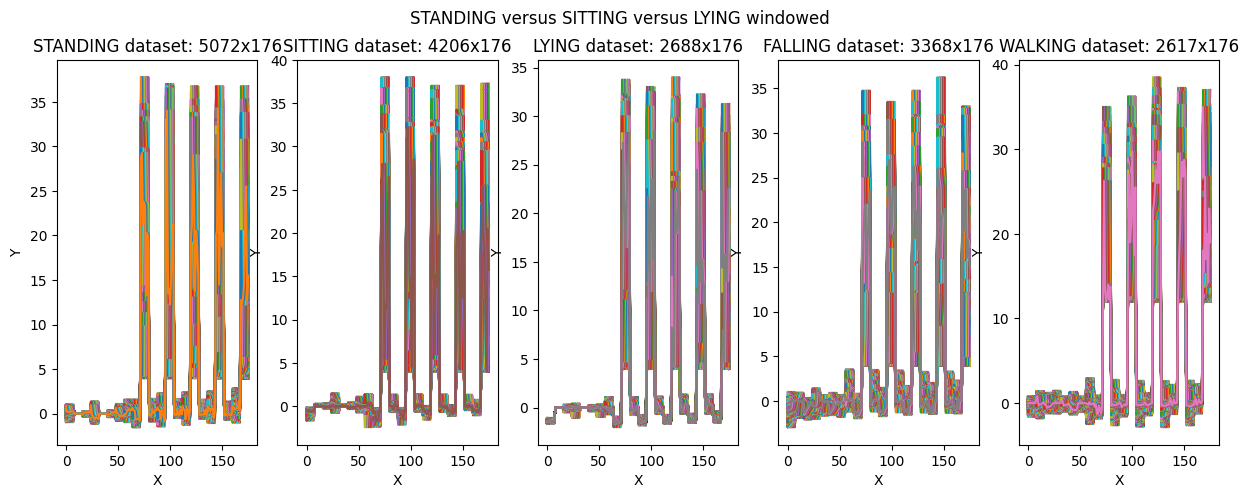

In [16]:
X_list = []  # features list
y_list = []  # labels list

fig, axes = plt.subplots(1, len(class_data), figsize=(15, 5))
fig.suptitle(f'STANDING versus SITTING versus LYING windowed')

for j in range(0, len(class_data)):
    LastPoint = len(X_list)  # record where the next data starts

    # Convert dataframe data to lists, and associate corresponding label.
    for i in range(len(df_dataList[j]) - WINDOW_SIZE):
        x = df_dataList[j].loc[i:i + WINDOW_SIZE - 1,
            :].unstack().to_frame().T.values.tolist()  # convert windowed datasets to list of lists and merge
        if WINDOW_CONCATENATE: x = df_dataList[0].loc[i:i + WINDOW_SIZE - 1,
                                   :].values.tolist()  # convert windowed datasets to list of lists and concatenate
        x = sum(x, [])  # flatten the window to single list.
        if WINDOW_SORT: x.sort()  # sort the window from high to low, hence merging the frames.
        X_list.append(x)
        y_list.append(j)

    # plot windowed data
    x_plt = [x for x in range(len(X_list[0]))]
    for i in range(LastPoint, len(X_list)):
        axes[j].plot(x_plt, (X_list[i]))
    axes[j].set(title=f'{class_data.get(j)} dataset: {len(X_list) - LastPoint}x{len(X_list[0])}', xlabel='X',
                ylabel='Y')

# Convert into numpy arrays.
X = np.array(X_list)
y = np.array(y_list)

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Add extra dimension to y so that it matches X.
y = torch.unsqueeze(y, 1)
print(f"Shapes for X: {X.shape} and y: {y.shape}")

# View the first example of features and labels
print(f"Values for first sample of X:\n {X[0]} \nand corresponding y: {y[0]}")
print(f"Values for next sample of X:\n {X[1]} \nand corresponding y: {y[1]}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE_PERCENT / 100)
print("New dataset lengths: X_train, X_test, y_train, y_test", len(X_train), len(X_test), len(y_train), len(y_test))


### Format the data into DataLoaders for use in training
1. convert to dataset format
2. convert to dataloaders with batch size.

In [17]:
from torch.utils.data import Dataset, DataLoader


# Computing on batches of data, our loss and evaluation metrics will be calculated **per batch** rather than across the whole dataset.
# Need to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

# Create the custom datasets, overload the len and getitem classes
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

# Create the dataloaders.
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,  # samples per batch
                              shuffle=True,  # shuffle data every epoch?
                              drop_last=True)  # ignores the last batch (when the number of examples in your dataset is not divisible by your batch_size
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                              shuffle=False,  # dont need to shuffle the test data
                             drop_last=True)

# Dataset dimensions
print(f"Split data into train / test:   Train={100 - TEST_SIZE_PERCENT}% Test={TEST_SIZE_PERCENT}%")
print(f"X-train, y-train shapes:        {X_train.shape} {y_train.shape}")
print(f"X-test, y-test shape:           {X_test.shape}  {y_test.shape}\n")
print(f"Length of train dataloader:     {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader:      {len(test_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print("Batch shape (features, labels):", train_features_batch.shape, train_labels_batch.shape)

Split data into train / test:   Train=80% Test=20%
X-train, y-train shapes:        torch.Size([14360, 176]) torch.Size([14360, 1])
X-test, y-test shape:           torch.Size([3591, 176])  torch.Size([3591, 1])

Length of train dataloader:     224 batches of 64
Length of test dataloader:      56 batches of 64
Batch shape (features, labels): torch.Size([64, 176]) torch.Size([64, 1])


### Define the model
3 fully connected layers with batch normalization before each one

In [18]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=input_size)
        self.fc1 = nn.Linear(in_features=input_size, out_features=64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=16)
        self.bn4 = nn.BatchNorm1d(num_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=output_size)
        self.relu = nn.ReLU()

    def get_weights(self):
        return self.weight

    def forward(self, x):
        out = self.bn1(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.bn2(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.bn3(out)
        out = self.fc3(out)
        out = self.bn4(out)
        out = self.fc4(out)

        out = torch.softmax(out, dim=1)

        return out


### Visualise the Model
`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through the model.\
Additionally we can add all the parameter lengths up to get a more accurate idea of the memory footprint.

In [20]:
!pip install torchinfo
from torchinfo import summary

model_0 = LinearModel(input_size=WINDOW_SIZE * FEATURE_COUNT, output_size=len(class_data))

# more precise memory requirements - lists all parameters and datatypes to retrieve the bits/bytes used.
size_model = 0
for param in model_0.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"Model parameters size: {size_model} bits | {size_model / 8e3:.2f} KB")

# Overall summary of layers with Torchinfo.
summary(model_0, input_size=[1, WINDOW_SIZE * FEATURE_COUNT])  # do a test pass through of an example input size


Model parameters size: 467104 bits | 58.39 KB


Layer (type:depth-idx)                   Output Shape              Param #
LinearModel                              [1, 5]                    --
├─BatchNorm1d: 1-1                       [1, 176]                  352
├─Linear: 1-2                            [1, 64]                   11,328
├─ReLU: 1-3                              [1, 64]                   --
├─BatchNorm1d: 1-4                       [1, 64]                   128
├─Linear: 1-5                            [1, 32]                   2,080
├─ReLU: 1-6                              [1, 32]                   --
├─BatchNorm1d: 1-7                       [1, 32]                   64
├─Linear: 1-8                            [1, 16]                   528
├─BatchNorm1d: 1-9                       [1, 16]                   32
├─Linear: 1-10                           [1, 5]                    85
Total params: 14,597
Trainable params: 14,597
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backw

In [23]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """

    correct = (y_pred.argmax(dim=1) == y_true).sum().item()
    return correct / len(y_true) * 100

### Train the model

EPOCH: 0 | F1: 0.33252
Train loss: 1.57950 | Test loss: 1.57589, Test acc: 35.13%
Distance: 2325
EPOCH: 160 | F1: 0.92533
Train loss: 1.12793 | Test loss: 1.11832, Test acc: 90.60%
Distance: 337
EPOCH: 320 | F1: 0.97352
Train loss: 1.02594 | Test loss: 1.01756, Test acc: 94.87%
Distance: 184
EPOCH: 480 | F1: 0.97352
Train loss: 0.98929 | Test loss: 0.97975, Test acc: 96.54%
Distance: 124
EPOCH: 640 | F1: 0.97352
Train loss: 0.96967 | Test loss: 0.96208, Test acc: 97.32%
Distance: 96
EPOCH: 800 | F1: 0.97352
Train loss: 0.95736 | Test loss: 0.95123, Test acc: 97.43%
Distance: 92
EPOCH: 960 | F1: 0.97352
Train loss: 0.95062 | Test loss: 0.94485, Test acc: 97.77%
Distance: 80
EPOCH: 1120 | F1: 0.97352
Train loss: 0.94567 | Test loss: 0.94028, Test acc: 97.94%
Distance: 74
EPOCH: 1280 | F1: 0.97352
Train loss: 0.94271 | Test loss: 0.93705, Test acc: 97.96%
Distance: 73
EPOCH: 1440 | F1: 0.97352
Train loss: 0.93806 | Test loss: 0.93397, Test acc: 98.10%
Distance: 68
EPOCH: 1599 | F1: 0.9735

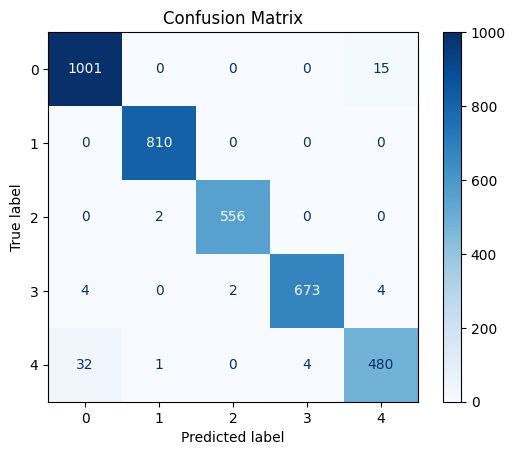

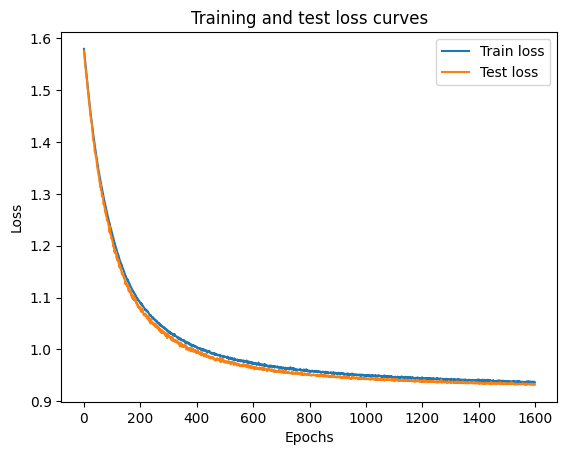

In [24]:
!pip install torchmetrics
from torchmetrics.classification import MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define model size and send to CPU
model_0 = LinearModel(input_size=WINDOW_SIZE * FEATURE_COUNT, output_size=len(class_data))

model_0.to(device)

loss_fn = nn.CrossEntropyLoss()

# setup the optimizer function
optimizer = SGD(params=model_0.parameters(), lr=LEARNING_RATE)
## Alternative optimizer.
# optimizer = Adam(params=model_0.parameters(), lr = LEARNING_RATE)

# setup F1 score
f1 = MulticlassF1Score(num_classes=len(class_data)).to(device)

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

###############################
# Start the main training loop
###############################
for epoch in range(NUM_EPOCHS):
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        X, y = X.to(device), y.to(device)
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        y = y.squeeze().long()

        loss = loss_fn(y_pred, y)
        train_loss += loss  # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()

    all_preds = []
    all_labels = []
    distance = 0

    # Calculations on test metrics should happen inside torch.inference_mode()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            X, y = X.to(device), y.to(device)
            test_pred = model_0(X)

            # 2. Calculate loss (accumulatively)
            y = y.squeeze().long()
            loss = loss_fn(test_pred, y)
            test_loss += loss_fn(test_pred, y)  # accumulatively add up the loss per epoch

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

            # Convert logits to class labels
            predicted_labels = torch.argmax(test_pred, dim=1)

            # Store predictions and true labels
            all_preds.extend(predicted_labels)
            all_labels.extend(y)

            # Calculate Hamming Distance Between predictions and correct categories
            a = predicted_labels.tolist()
            b = y.tolist()

            for i in range(len(a)):
                if a[i] != b[i]:
                    distance += 1

                    # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening in the epoch loop
    if epoch % (NUM_EPOCHS / 10) == 0 or epoch == NUM_EPOCHS - 1:
        print(f"EPOCH: {epoch} | F1: {f1(test_pred, y):.5f}")
        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        print(f'Distance: {distance}')

    # keep a history to view loss curves. Detach the tensors from the computation graphs.
    epoch_count.append(epoch)
    train_loss_values.append(train_loss.detach())
    test_loss_values.append(test_loss.detach())

# Need to do convert the tensors to lists otherwise you will get a TypeError when using CUDA
if device == "cuda":
    all_labels = [x.item() for x in all_labels]
    all_preds = [x.item() for x in all_preds]
    train_loss_values = [x.item() for x in train_loss_values]
    test_loss_values = [x.item() for x in test_loss_values]

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

**export the model**

In [ ]:
import onnx_tool

MODEL_PATH = "my_Linear_model_walk_rel_acc.onnx"
print(MODEL_PATH)
with torch.no_grad():
    torch.onnx.export(model_0, torch.randn(1, WINDOW_SIZE * FEATURE_COUNT).to(device), MODEL_PATH, opset_version=11)
onnx_tool.model_profile(MODEL_PATH, save_profile="my_Linear-profile_relative.txt")
